This is an example script where we try to understand Pearl's structural counterfactuals (SCF) generation process (abduction - action - prediction) in the context of situation testing (SI). We want to be able to take a factual tuple {x^F} and return it's counterfactual by changing (only?) the protected attribute A from a^F=a to a^CF=a'. We believe to have two clear scenarios here regarding the latent space (or exogenous variables): either we have them by having generated ourselves the data or we don't and most estimate them using, e.g., MCMC. 

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# overall params
random.seed(2022)
n = 1000

### Figure 1 from Karimi et al. (2020)
With the DAG: X1->Y, X1->X2, X->Y.

In [3]:
u1 = 10000*np.random.poisson(lam=10, size=n)
u2 = 2500*np.random.normal(loc=0.0, scale=1.0, size=n)

# annual salary
x1 = u1
# account balance
x2 = (3/10)*x1 + u2
# loan approval
y = np.sign(x1 + 5*x2 - 225000)

(array([412.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 588.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

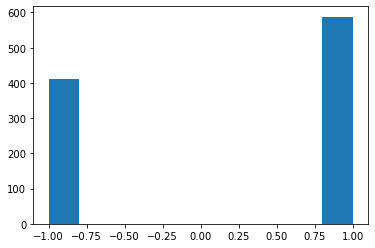

In [4]:
# plot the factual distribution
plt.hist(y)

In [5]:
# make a dataset for the observables*
# *include unobservables too... here, imagine you ran the MCMC before and estimated u|evidence
d = {'Y': y, 'X1': x1, 'X2': x2, 'U1_hat': u1, 'U2_hat': u2}
data = pd.DataFrame(d)
data.head(10)

,Y,X1,X2,U1_hat,U2_hat
0,-1.0,80000,28959.229435,80000,4959.229435
1,-1.0,60000,19167.894829,60000,1167.894829
2,-1.0,80000,26439.781762,80000,2439.781762
3,1.0,90000,32479.002130,90000,5479.002130
4,1.0,120000,40095.329960,120000,4095.329960
5,-1.0,70000,18357.988615,70000,-2642.011385
6,-1.0,80000,23227.399615,80000,-772.600385
7,1.0,100000,25751.746805,100000,-4248.253195
8,1.0,120000,36228.660833,120000,228.660833
9,1.0,110000,29841.984164,110000,-3158.015836


In [ ]:
# # consider the individual with x1=75,000 and x2=25,000
# y_if = np.sign(75000 + 5*25000 - 225000)
# y_if

In [8]:
# consider individual i: what is the counterfactual of y_i?
# here, in ST, want the STRUCTURAL COUNTERFACTUAL x_scf, not too interested in y_scf
# because want to match x_scf with those that don't share the protected attribute memebership of i
i = 3
data.loc[i, ]

Y             1.00000
X1        90000.00000
X2        32479.00213
U1_hat    90000.00000
U2_hat     5479.00213
Name: 3, dtype: float64

In [7]:
# Step 1: Abduction
# Get U's given the evidence X's [assuming causal sufficiency and, ofc, a known causal graph]

# u1 given x1: from Fig.1, x1 = u1 and thus u1 = x1
u1_i = data.loc[i, 'X1']
print(u1_i)

# u2 given x2: from Fig.1, x2 = (3/10)*x1 + u2 and thus u2 = x2 - (3/10)*x1
u2_i = data.loc[i, 'X2'] - (3/10)*data.loc[i, 'X1']
print(u2_i)

90000
5479.00212963756


In [9]:
# Step 2: Action
# Given the SCM, intervene it accordingly using the do-operator 
delta = 5000

# Org SCM M:
# x1 = u1             [salary]
# x2 = (3/10)*x1 + u2 [balance]

# do(X1 := X1 + delta), then M':
# X1' := X1 + delta
# X2 = (3/10)*X1' + U2

# Step 3: Prediction (notice at at i-level)
# Apply the chagnes on M' and get the scf tuple 

x1_i_scf = data.loc[i, 'X1'] + delta
print(x1_i_scf)

x2_i_scf = (3/10)*x1_i_scf + u2_i
print(x2_i_scf)

95000
33979.00212963756


In [11]:
print(data.loc[i, 'Y'])
# vs
print(np.sign(x1_i_scf + 5*x2_i_scf - 225000))

1.0
1.0


This abduction-action-prediction from Karimi et al. is very usful for situation testing because all the focus is on profucing the structural counterfactual tuple for the attribute space; we don't 'care' for Y!

This means, wrt to ST, that we can generate X_CF without having to know the decision-maker (i.e., model agnostic). Ofc, the assumption here is that we have a SCM model that is known. Further more, SCM needs to be estimated to obtain the functional form for carrying out the three steps... meaning that we further have to assume (potentially) (1) causal sufficiency and (2) additive noise models for a nice estimation. Although these are considerable assumptions, it's standard within the literature.

ST simplifies this step in that we only care about switching the protected attribute A, which is usually 0 or 1. Further, we are not interested in flipping the decision, but in checking whether the decision flips or not!

Furthermore, we should consider the types of potential interventions presented in this paper... and extend situation testing beyond flipping A?!

Given {x^F}, we can generate {x^SCF} and from this generated tuple try to match individuals that don't share the protected attribute of the complainant... creating out counterfactual group.

In practice, we won't have access to U (i.e., the latent space) but we can approximated using MCMC (like in Kusner at al.).

### Figure 1 with $A$
with the DAG: X1->Y, X1->X2, X->Y, A->X1, A->X2 such that $A$ is gender (A=1 female, A=0 male).

(array([665.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 335.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

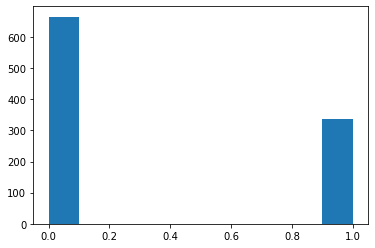

In [12]:
p_men = 0.65
uA = random.choices(population=[0, 1], weights=[p_men, (1 - p_men)], k=n)
plt.hist(uA)

In [13]:
#u1 = 10000*np.random.poisson(lam=10, size=n)
#u2 = 2500*np.random.normal(loc=0.0, scale=1.0, size=n)
#uA = see previous cell!

# gender 
A = np.asanyarray(uA)
# and its weights (systematic issue) | we avoid direct effects (as it would be ilegal and inline with Hecker's view)
beta1 = -9500
beta2 = -500

# annual salary
n_x1 = u1 + beta1*A
# account balance
n_x2 = (3/10)*n_x1 + u2 + beta2*A
# loan approval
n_y = np.sign(n_x1 + 5*n_x2 - 225000)

(array([446.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 554.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

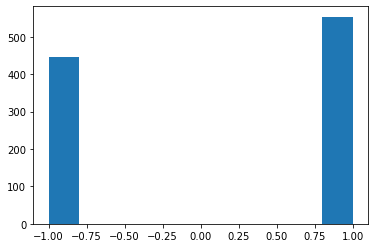

In [14]:
# plot the factual distribution
plt.hist(n_y)

In [15]:
# make a dataset for the observables*
# *include unobservables too... here, imagine you ran the MCMC before and estimated u|evidence
d = {'Y': y, 'X1': x1, 'X2': x2, 
     'Gender': A, 'nY': n_y, 'nX1': n_x1, 'nX2': n_x2,
     'U1_hat': u1, 'U2_hat': u2, 'uA': uA}
data = pd.DataFrame(d)
data.head(10)

,Y,X1,X2,Gender,nY,nX1,nX2,U1_hat,U2_hat,uA
0,-1.0,80000,28959.229435,0,-1.0,80000,28959.229435,80000,4959.229435,0
1,-1.0,60000,19167.894829,0,-1.0,60000,19167.894829,60000,1167.894829,0
2,-1.0,80000,26439.781762,0,-1.0,80000,26439.781762,80000,2439.781762,0
3,1.0,90000,32479.002130,0,1.0,90000,32479.002130,90000,5479.002130,0
4,1.0,120000,40095.329960,1,1.0,110500,36745.329960,120000,4095.329960,1
5,-1.0,70000,18357.988615,1,-1.0,60500,15007.988615,70000,-2642.011385,1
6,-1.0,80000,23227.399615,0,-1.0,80000,23227.399615,80000,-772.600385,0
7,1.0,100000,25751.746805,0,1.0,100000,25751.746805,100000,-4248.253195,0
8,1.0,120000,36228.660833,1,1.0,110500,32878.660833,120000,228.660833,1
9,1.0,110000,29841.984164,1,1.0,100500,26491.984164,110000,-3158.015836,1


In [36]:
# total of females
n_f = data[data['Gender']==1].shape[0]
# total of males
n_m = data[data['Gender']==0].shape[0]

# unbiased
print('female unbiased')
print(data[(data['Gender']==1) & (data['Y']==1)].shape[0] / n_f)
print('male unbiased')
print(data[(data['Gender']==0) & (data['Y']==1)].shape[0] / n_m)

# biased
print('female biased')
print(data[(data['Gender']==1) & (data['nY']==1)].shape[0] / n_f)
print('male biased')
print(data[(data['Gender']==0) & (data['nY']==1)].shape[0] / n_m)

# TODO: would this show in a trained model?

female unbiased
0.6119402985074627
male unbiased
0.5759398496240602
female biased
0.5104477611940299
male biased
0.5759398496240602


### Would this translate into some trained model?

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, Lasso
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBRegressor, XGBClassifier
# from catboost import CatBoostClassifier

In [38]:
data.columns

Index(['Y', 'X1', 'X2', 'Gender', 'nY', 'nX1', 'nX2', 'U1_hat', 'U2_hat',
       'uA'],
      dtype='object')

In [39]:
u_data = data[['Y', 'X1', 'X2', 'Gender']].copy()
print(u_data.shape)

b_data = data[['nY', 'nX1', 'nX2', 'Gender']].copy()
print(b_data.shape)

(1000, 4)
(1000, 4)


In [51]:
# todo: let's do a simple logit here, later we can reuse the FairEncoder code and streamline multiple models
# todo: also create an utils files accordingly
# todo: get comfortable with Pipeline

b_data['nY2'] = np.where(b_data['nY']==-1, 0 ,b_data['nY'])
print(b_data[['nY', 'nY2']].head(10))

targets = ['nY2', 'nY']
y = b_data['nY2']
X = b_data.drop(columns=targets)

    nY  nY2
0 -1.0  0.0
1 -1.0  0.0
2 -1.0  0.0
3  1.0  1.0
4  1.0  1.0
5 -1.0  0.0
6 -1.0  0.0
7  1.0  1.0
8  1.0  1.0
9  1.0  1.0


In [52]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)

In [53]:
clf = LogisticRegression(random_state=0).fit(X_tr, y_tr.values.ravel())

In [54]:
clf.coef_

array([[ 5.75985932e-05,  1.33050693e-04, -3.08062261e+00]])

In [57]:
y_pr = clf.predict(X_te)

In [59]:
conf_matrix = confusion_matrix(y_pr, y_te)
conf_matrix

array([[157,  30],
       [ 62, 251]], dtype=int64)

In [108]:
# todo: move later to some utils.py files 
def calculate_cm(true, preds):
    
    # Obtain the confusion matrix
    cm = confusion_matrix(preds, true)
    
    # Return all
    cm_dict = dict()

    #  https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = cm.sum(axis=0) - np.diag(cm)
    cm_dict['FP'] = FP
    FN = cm.sum(axis=1) - np.diag(cm)
    cm_dict['FN'] = FN
    TP = np.diag(cm)
    cm_dict['TP'] = TP
    TN = cm.sum() - (FP + FN + TP)
    cm_dict['TN'] = TN
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    cm_dict['TPR'] = TPR
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    cm_dict['TNR'] = TNR
    
    # todo: expand dict for others
    # Precision or positive predictive valbue
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)

    #return cm_dict
    return TPR[0] #esto esta bien!

In [110]:
# reference group (males, or A=0): group 2
aux = X_te.copy()
aux['target'] = y_te

# Filter the data
g1 = X_te[X_te['Gender'] == 1]
g2 = X_te[X_te['Gender'] == 0]

# Filter the ground truth
g1_true = aux[aux['Gender'] == 1].target
g2_true = aux[aux['Gender'] == 0].target

# Do predictions
p1 = clf.predict(g1)
p2 = clf.predict(g2)

# Extract metrics for each group | here, taking the true positive rate
res1 = calculate_cm(p1, g1_true)
print(res1)
res2 = calculate_cm(p2, g2_true)
print(res2)

res1 - res2

1.0
0.5539568345323741


0.4460431654676259

In [115]:
#https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/
# TPR = TP / (TP + FP)

print(confusion_matrix(p1, g1_true))
tpr_1 = confusion_matrix(p1, g1_true)[0][0] / (confusion_matrix(p1, g1_true)[0][0] + confusion_matrix(p1, g1_true)[0][1])
print(tpr_1)

print(confusion_matrix(p2, g2_true))
tpr_2 = confusion_matrix(p2, g2_true)[0][0] / (confusion_matrix(p2, g2_true)[0][0] + confusion_matrix(p2, g2_true)[0][1])
print(tpr_2)

[[80 30]
 [ 0 55]]
0.7272727272727273
[[ 77   0]
 [ 62 196]]
1.0


In [111]:
def metric_calculator(model, data: pd.DataFrame, truth: pd.DataFrame, col: str, group1, group2):
    #reference group is group2!!
    
    aux = data.copy()
    aux["target"] = truth

    # Filter the data
    g1 = data[data[col] == group1]
    g2 = data[data[col] == group2]

    # Filter the ground truth
    g1_true = aux[aux[col] == group1].target
    g2_true = aux[aux[col] == group2].target

    # Do predictions
    p1 = model.predict(g1)
    p2 = model.predict(g2)

    # Extract metrics for each group | here, taking the true positive rate
    res1 = calculate_cm(p1, g1_true)
    print(res1)
    res2 = calculate_cm(p2, g2_true)
    print(res2)
    
    return res1 - res2

In [112]:
metric_calculator(model=clf, data=X_te, truth=y_te, col='Gender', group1=1, group2=0)

1.0
0.5539568345323741


0.4460431654676259

In [113]:
metric_calculator(model=clf, data=X_tr, truth=y_tr, col='Gender', group1=1, group2=0)

1.0
0.6713286713286714


0.32867132867132864